In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

# where your CSVs are (use "." if they are in the same directory as the notebook)
DATA_DIRS = [Path("."), Path("/mnt/data")]

def load_yahoo_csv(filename: str, ticker: str) -> pd.DataFrame:
    # try current folder, then /mnt/data
    for d in DATA_DIRS:
        p = d / filename
        if p.exists():
            df = pd.read_csv(p)
            break
    else:
        raise FileNotFoundError(f"Could not find {filename} in {DATA_DIRS}")

    # standardize columns
    df = df.rename(columns={
        "Date": "Date",
        "Close/Last": "Close",
        "Open": "Open",
        "High": "High",
        "Low": "Low",
        "Volume": "Volume",
    })

    # strip "$" and cast
    for col in ["Open", "High", "Low", "Close"]:
        df[col] = df[col].astype(str).str.replace("$", "", regex=False).astype(float)

    df["Volume"] = df["Volume"].astype(int)
    # Changed format from "%m-%d-%Y" to "%m/%d/%Y" to match the actual date format in the CSV
    df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
    df = df.sort_values("Date").reset_index(drop=True)
    df["Ticker"] = ticker
    return df[["Date","Open","High","Low","Close","Volume","Ticker"]]

aapl = load_yahoo_csv("AAPL.csv", "AAPL")
amzn = load_yahoo_csv("AMZN.csv", "AMZN")
qcom = load_yahoo_csv("QCOM.csv", "QCOM")

raw = pd.concat([aapl, amzn, qcom], ignore_index=True)
raw.head()

,Date,Open,High,Low,Close,Volume,Ticker
0,2015-09-09,28.4400,28.5050,27.4425,27.5375,339031120,AAPL
1,2015-09-10,27.5675,28.3206,27.4750,28.1425,251203080,AAPL
2,2015-09-11,27.9475,28.5525,27.9400,28.5525,199175000,AAPL
3,2015-09-14,29.1450,29.2225,28.7150,28.8275,233118280,AAPL
4,2015-09-15,28.9825,29.1325,28.6050,29.0700,172873400,AAPL


In [4]:
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # log return
    df["LogRet"] = np.log(df["Close"]).diff()

    # SMAs/EMAs
    df["SMA_10"]  = df["Close"].rolling(10).mean()
    df["SMA_20"]  = df["Close"].rolling(20).mean()
    df["EMA_10"]  = df["Close"].ewm(span=10, adjust=False).mean()
    df["EMA_20"]  = df["Close"].ewm(span=20, adjust=False).mean()
    # RSI-14
    delta = df["Close"].diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    rs = up.ewm(span=14, adjust=False).mean() / (down.ewm(span=14, adjust=False).mean() + 1e-8)
    df["RSI_14"] = 100 - (100 / (1 + rs))

    # MACD + signal
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    macd  = ema12 - ema26
    df["MACD"] = macd
    df["MACD_Signal"] = macd.ewm(span=9, adjust=False).mean()

    # 20D volatility of log returns
    df["Volatility_20"] = df["LogRet"].rolling(20).std()

    df = df.dropna().reset_index(drop=True)
    return df

feature_cols = ["Open","High","Low","Close","Volume","LogRet",
                "SMA_10","SMA_20","EMA_10","EMA_20","RSI_14",
                "MACD","MACD_Signal","Volatility_20"]

frames = []
for t in ["AAPL","AMZN","QCOM"]:
    ft = add_indicators(raw[raw["Ticker"]==t].sort_values("Date"))
    # target = NEXT-day log return
    ft["NextLogRet"] = ft["LogRet"].shift(-1)
    ft = ft.dropna().reset_index(drop=True)
    frames.append(ft.assign(Ticker=t))

data = pd.concat(frames, ignore_index=True)
data.head()


,Date,Open,High,Low,Close,Volume,Ticker,LogRet,SMA_10,SMA_20,EMA_10,EMA_20,RSI_14,MACD,MACD_Signal,Volatility_20,NextLogRet
0,2015-10-07,27.9350,27.9425,27.3525,27.6950,186871080,AAPL,-0.004773,27.85850,28.242750,27.837799,27.946977,50.387447,-0.072015,0.030623,0.013641,-0.011622
1,2015-10-08,27.5475,27.5475,27.0525,27.3750,246989040,AAPL,-0.011622,27.72100,28.204375,27.753654,27.892503,42.713489,-0.106716,0.003155,0.012900,0.023645
2,2015-10-09,27.5000,28.0700,27.3725,28.0300,210882480,AAPL,0.023645,27.65625,28.178250,27.803899,27.905598,57.868165,-0.080436,-0.013563,0.013636,-0.004649
3,2015-10-12,28.1825,28.1875,27.8600,27.9000,121547320,AAPL,-0.004649,27.63525,28.131875,27.821372,27.905065,54.562646,-0.069301,-0.024711,0.013429,0.001701
4,2015-10-13,27.7050,28.1125,27.6700,27.9475,131883160,AAPL,0.001701,27.70350,28.075750,27.844304,27.909107,55.631150,-0.055997,-0.030968,0.013248,-0.014234


In [5]:
from sklearn.preprocessing import StandardScaler

def time_split(df, train=0.7, val=0.1):
    n = len(df); i1 = int(n*train); i2 = int(n*(train+val))
    return df.iloc[:i1], df.iloc[i1:i2], df.iloc[i2:]

# split & scale *per ticker* to avoid leakage between stocks
splits = {}
scalers = {}

for t in ["AAPL","AMZN","QCOM"]:
    d = data[data["Ticker"]==t].reset_index(drop=True)
    tr, va, te = time_split(d, 0.7, 0.1)
    scaler = StandardScaler().fit(tr[feature_cols])
    scalers[t] = scaler
    splits[t] = {
        "train_raw": tr, "val_raw": va, "test_raw": te,
        "train_X": pd.DataFrame(scaler.transform(tr[feature_cols]), columns=feature_cols, index=tr.index),
        "val_X":   pd.DataFrame(scaler.transform(va[feature_cols]), columns=feature_cols, index=va.index),
        "test_X":  pd.DataFrame(scaler.transform(te[feature_cols]), columns=feature_cols, index=te.index),
    }

# quick sanity check
{t: {k: v.shape if isinstance(v, pd.DataFrame) else len(v) for k,v in splits[t].items() if "X" in k} for t in splits}


{'AAPL': {'train_X': (1745, 14), 'val_X': (249, 14), 'test_X': (499, 14)},
 'AMZN': {'train_X': (1745, 14), 'val_X': (249, 14), 'test_X': (499, 14)},
 'QCOM': {'train_X': (1745, 14), 'val_X': (249, 14), 'test_X': (499, 14)}}

In [6]:
import numpy as np

def make_windows_returns(Xdf, rawdf, lookback=60):
    """
    Build windows ending at time t (lookback long), target = NextLogRet at t+1.
    Also return prev_close (price at t) and next_close_true (price at t+1) to score on price.
    """
    X = Xdf.values
    y = rawdf["NextLogRet"].values
    close = rawdf["Close"].values

    X_out, y_out, prev_close, next_close = [], [], [], []
    for i in range(len(X) - lookback):
        t = i + lookback - 1
        X_out.append(X[i:i+lookback])
        y_out.append(y[t])
        prev_close.append(close[t])
        next_close.append(close[t+1])
    return np.array(X_out), np.array(y_out), np.array(prev_close), np.array(next_close)

def concat_windows(splits, split_name, lookback=60):
    Xs, ys, pcs, ncs, ids = [], [], [], [], []
    for t in ["AAPL","AMZN","QCOM"]:
        Xdf = splits[t][f"{split_name}_X"]
        raw = splits[t][f"{split_name}_raw"]
        X, y, pc, nc = make_windows_returns(Xdf, raw, lookback=lookback)
        if len(X) > 0:
            Xs.append(X); ys.append(y); pcs.append(pc); ncs.append(nc); ids += [t]*len(y)
    return (np.concatenate(Xs), np.concatenate(ys),
            np.concatenate(pcs), np.concatenate(ncs), np.array(ids))

LOOKBACK = 60  # you can tune later

trX, trYret, trPrevC, trNextC, trID = concat_windows(splits, "train", LOOKBACK)
vaX, vaYret, vaPrevC, vaNextC, vaID = concat_windows(splits, "val",   LOOKBACK)
teX, teYret, tePrevC, teNextC, teID = concat_windows(splits, "test",  LOOKBACK)

trX.shape, vaX.shape, teX.shape


((5055, 60, 14), (567, 60, 14), (1317, 60, 14))

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression

def metrics_price(y_true_price, y_pred_price, y_true_ret=None, y_pred_ret=None):
    rmse = float(np.sqrt(np.mean((y_true_price - y_pred_price)**2)))
    mae  = float(np.mean(np.abs(y_true_price - y_pred_price)))
    mape = float(np.mean(np.abs((y_true_price - y_pred_price) / (y_true_price + 1e-8)))) * 100.0
    dir_acc = np.nan
    if (y_true_ret is not None) and (y_pred_ret is not None):
        dir_acc = float(np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))) * 100.0
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "Directional_Accuracy_%": dir_acc}

# ----- Baseline 1: Naive (returns = 0) -----
naive_ret_pred  = np.zeros_like(teYret)
naive_price_pred = tePrevC * np.exp(naive_ret_pred)     # next_price = prev_close * e^(0) = prev_close
baseline_naive = metrics_price(teNextC, naive_price_pred, teYret, naive_ret_pred)
print("Naive baseline (returns=0):", baseline_naive)

# ----- Baseline 2: Linear Regression on returns (flattened window) -----
trX_flat = trX.reshape(len(trX), -1)
teX_flat = teX.reshape(len(teX), -1)

lin = LinearRegression().fit(trX_flat, trYret)
lin_ret_pred   = lin.predict(teX_flat)
lin_price_pred = tePrevC * np.exp(lin_ret_pred)
baseline_linear = metrics_price(teNextC, lin_price_pred, teYret, lin_ret_pred)
print("Linear baseline (returns->price):", baseline_linear)


Naive baseline (returns=0): {'RMSE': 3.812613009142039, 'MAE': 2.645785876993166, 'MAPE': 1.4210595865451463, 'Directional_Accuracy_%': 0.15186028853454822}
Linear baseline (returns->price): {'RMSE': 4.692742244421703, 'MAE': 3.466162941351653, 'MAPE': 1.8623890980464086, 'Directional_Accuracy_%': 51.86028853454822}


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class ReturnDataset(Dataset):
    """
    Holds windows of features and next-day returns.
    Can also store stock IDs for ID-aware models.
    """
    def __init__(self, X, yret, ids=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(yret, dtype=torch.float32)
        if ids is not None:
            uniq = sorted(list(set(ids)))
            self.id_map = {t:i for i,t in enumerate(uniq)}
            self.ids = torch.tensor([self.id_map[t] for t in ids], dtype=torch.long)
        else:
            self.ids = None

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, i):
        if self.ids is None:
            return self.X[i], self.y[i]
        return self.X[i], self.y[i], self.ids[i]


In [11]:
import torch.nn as nn

class LSTMReg2(nn.Module):
    """Pooled LSTM model (no stock ID)"""
    def __init__(self, nfeat, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(nfeat, hidden, num_layers=layers, dropout=dropout, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)

    def forward(self, x):
        o,_ = self.lstm(x)   
        o   = o[:,-1,:]      
        return self.fc(o).squeeze(-1)


class LSTMReg2_ID(nn.Module):
    """ID-aware LSTM with stock embedding"""
    def __init__(self, nfeat, n_ids, emb=8, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.emb  = nn.Embedding(n_ids, emb)
        self.lstm = nn.LSTM(nfeat+emb, hidden, num_layers=layers, dropout=dropout, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)

    def forward(self, x, ids):
        e = self.emb(ids)                    
        e = e.unsqueeze(1).repeat(1, x.shape[1], 1)  
        z = torch.cat([x, e], dim=-1)        
        o,_ = self.lstm(z)
        o   = o[:,-1,:]
        return self.fc(o).squeeze(-1)


In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_lstm(model, tr_dl, va_dl, idaware=False, epochs=30, lr=3e-4, patience=6):
    model = model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    bad = 0
    best_state = None
    tr_hist, va_hist = [], []

    for ep in range(epochs):
        # ---- training ----
        model.train()
        bl = []
        for batch in tr_dl:
            opt.zero_grad()
            if idaware:
                X,y,ids = batch
                X,y,ids = X.to(DEVICE), y.to(DEVICE), ids.to(DEVICE)
                pred = model(X, ids)
            else:
                X,y = batch
                X,y = X.to(DEVICE), y.to(DEVICE)
                pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            bl.append(loss.item())
        tr_hist.append(float(np.mean(bl)))

        # ---- validation ----
        model.eval(); vl=[]
        with torch.no_grad():
            for batch in va_dl:
                if idaware:
                    X,y,ids = batch
                    X,y,ids = X.to(DEVICE), y.to(DEVICE), ids.to(DEVICE)
                    pred = model(X, ids)
                else:
                    X,y = batch
                    X,y = X.to(DEVICE), y.to(DEVICE)
                    pred = model(X)
                vl.append(loss_fn(pred, y).item())
        v = float(np.mean(vl)); va_hist.append(v)

        # ---- early stopping ----
        if v < best_val - 1e-6:
            best_val = v
            bad = 0
            best_state = {k:v2.cpu().clone() for k,v2 in model.state_dict().items()}
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, tr_hist, va_hist


def predict_lstm(model, dl, idaware=False):
    model.eval(); outs=[]
    with torch.no_grad():
        for batch in dl:
            if idaware:
                X,_,ids = batch
                X,ids = X.to(DEVICE), ids.to(DEVICE)
                p = model(X, ids).cpu().numpy()
            else:
                X,_ = batch
                X = X.to(DEVICE)
                p = model(X).cpu().numpy()
            outs.append(p)
    return np.concatenate(outs)


In [13]:
batch = 128

dl_tr_plain = DataLoader(ReturnDataset(trX, trYret), batch_size=batch, shuffle=True)
dl_va_plain = DataLoader(ReturnDataset(vaX, vaYret), batch_size=batch, shuffle=False)
dl_te_plain = DataLoader(ReturnDataset(teX, teYret), batch_size=batch, shuffle=False)

dl_tr_id = DataLoader(ReturnDataset(trX, trYret, trID), batch_size=batch, shuffle=True)
dl_va_id = DataLoader(ReturnDataset(vaX, vaYret, vaID), batch_size=batch, shuffle=False)
dl_te_id = DataLoader(ReturnDataset(teX, teYret, teID), batch_size=batch, shuffle=False)


In [14]:
# train pooled LSTM
plain = LSTMReg2(nfeat=trX.shape[-1], hidden=128, layers=2, dropout=0.2)
plain, tr_loss_p, va_loss_p = train_lstm(plain, dl_tr_plain, dl_va_plain,
                                         idaware=False, epochs=30, lr=3e-4, patience=6)

# train ID-aware LSTM
withid = LSTMReg2_ID(nfeat=trX.shape[-1], n_ids=len(set(trID)), emb=8, hidden=128, layers=2, dropout=0.2)
withid, tr_loss_id, va_loss_id = train_lstm(withid, dl_tr_id, dl_va_id,
                                            idaware=True, epochs=30, lr=3e-4, patience=6)

# predictions
pred_plain_ret = predict_lstm(plain, dl_te_plain, idaware=False)
pred_plain_price = tePrevC * np.exp(pred_plain_ret)
lstm_plain_metrics = metrics_price(teNextC, pred_plain_price, teYret, pred_plain_ret)

pred_id_ret = predict_lstm(withid, dl_te_id, idaware=True)
pred_id_price = tePrevC * np.exp(pred_id_ret)
lstm_id_metrics = metrics_price(teNextC, pred_id_price, teYret, pred_id_ret)

print("LSTM pooled (returns->price):", lstm_plain_metrics)
print("LSTM + Stock ID (returns->price):", lstm_id_metrics)


LSTM pooled (returns->price): {'RMSE': 3.8573287964692637, 'MAE': 2.7164779435223756, 'MAPE': 1.452247322043674, 'Directional_Accuracy_%': 50.34168564920274}
LSTM + Stock ID (returns->price): {'RMSE': 3.8732211443594418, 'MAE': 2.7574467176764683, 'MAPE': 1.4684661271119517, 'Directional_Accuracy_%': 48.9749430523918}


In [16]:
# Flatten [N, lookback, features] -> [N, lookback*features]
trX_flat = trX.reshape(len(trX), -1)
vaX_flat = vaX.reshape(len(vaX), -1)
teX_flat = teX.reshape(len(teX), -1)

# Use train+val for final training (we already tuned lookback earlier)
X_gb = np.vstack([trX_flat, vaX_flat])
yret_gb = np.concatenate([trYret, vaYret])


In [17]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=700,              # plenty of trees; uses early_stopping by default
    l2_regularization=1e-4,
    early_stopping=True,
    n_iter_no_change=30
)
hgb.fit(X_gb, yret_gb)

# Predict returns on test, then convert to next-day price
hgb_ret_pred  = hgb.predict(teX_flat)
hgb_price_pred = tePrevC * np.exp(hgb_ret_pred)
hgb_metrics = metrics_price(teNextC, hgb_price_pred, teYret, hgb_ret_pred)
print("HistGB Regressor (returns->price):", hgb_metrics)


HistGB Regressor (returns->price): {'RMSE': 4.005383760282774, 'MAE': 2.903145352065105, 'MAPE': 1.5398894103292755, 'Directional_Accuracy_%': 50.64540622627183}


In [18]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Labels: 1 if next-day return > 0 else 0
y_cls_tr = (trYret > 0).astype(int)
y_cls_va = (vaYret > 0).astype(int)
y_cls_te = (teYret > 0).astype(int)

X_cls = np.vstack([trX_flat, vaX_flat])
y_cls = np.concatenate([y_cls_tr, y_cls_va])

hgb_cls = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=700,
    l2_regularization=1e-4,
    early_stopping=True,
    n_iter_no_change=30
)
hgb_cls.fit(X_cls, y_cls)

proba_up = hgb_cls.predict_proba(teX_flat)[:, 1]
pred_up  = (proba_up >= 0.5).astype(int)

acc = accuracy_score(y_cls_te, pred_up)
f1  = f1_score(y_cls_te, pred_up)
try:
    auc = roc_auc_score(y_cls_te, proba_up)
except ValueError:
    auc = float("nan")  # if only one class present
print({"Direction_Accuracy_%": acc*100, "F1": f1, "ROC_AUC": auc})


{'Direction_Accuracy_%': 51.32877752467729, 'F1': 0.6074709124311084, 'ROC_AUC': 0.5148132016810226}


In [23]:
import numpy as np

def make_windows_returns(Xdf, rawdf, lookback):
    X = Xdf.values
    y = rawdf["NextLogRet"].values
    close = rawdf["Close"].values

    X_out, y_out, prev_close, next_close = [], [], [], []
    for i in range(len(X) - lookback):
        t = i + lookback - 1
        X_out.append(X[i:i+lookback])
        y_out.append(y[t])
        prev_close.append(close[t])
        next_close.append(close[t+1])
    return np.array(X_out), np.array(y_out), np.array(prev_close), np.array(next_close)

def concat_windows_for_lookback(splits, lookback):
    def build_split(split_name):
        Xs, ys, pcs, ncs, ids = [], [], [], [], []
        for t in ["AAPL","AMZN","QCOM"]:
            Xdf = splits[t][f"{split_name}_X"]
            raw = splits[t][f"{split_name}_raw"]
            X, y, pc, nc = make_windows_returns(Xdf, raw, lookback)
            if len(X) > 0:
                Xs.append(X); ys.append(y); pcs.append(pc); ncs.append(nc); ids += [t]*len(y)
        if not Xs: return None
        return (np.concatenate(Xs), np.concatenate(ys),
                np.concatenate(pcs), np.concatenate(ncs), np.array(ids))
    return build_split("train"), build_split("val"), build_split("test")


In [24]:
LOOKBACKS = [30, 60]
HIDDENS   = [64, 128]
EPOCHS    = 30
PATIENCE  = 6
BATCH     = 128
LR        = 3e-4
DROPOUT   = 0.2


In [25]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

results = []

for lookback in LOOKBACKS:
    tr, va, te = concat_windows_for_lookback(splits, lookback)
    if tr is None or va is None or te is None:
        print(f"[WARN] Not enough data for lookback={lookback}")
        continue

    trX, trYret, trPrevC, trNextC, trID = tr
    vaX, vaYret, vaPrevC, vaNextC, vaID = va
    teX, teYret, tePrevC, teNextC, teID = te

    # dataloaders
    dl_tr_plain = DataLoader(ReturnDataset(trX, trYret), batch_size=BATCH, shuffle=True)
    dl_va_plain = DataLoader(ReturnDataset(vaX, vaYret), batch_size=BATCH, shuffle=False)
    dl_te_plain = DataLoader(ReturnDataset(teX, teYret), batch_size=BATCH, shuffle=False)

    dl_tr_id = DataLoader(ReturnDataset(trX, trYret, trID), batch_size=BATCH, shuffle=True)
    dl_va_id = DataLoader(ReturnDataset(vaX, vaYret, vaID), batch_size=BATCH, shuffle=False)
    dl_te_id = DataLoader(ReturnDataset(teX, teYret, teID), batch_size=BATCH, shuffle=False)

    for hidden in HIDDENS:
        # --- LSTM pooled
        plain = LSTMReg2(nfeat=trX.shape[-1], hidden=hidden, layers=2, dropout=DROPOUT)
        plain, tr_loss_p, va_loss_p = train_lstm(
            plain, dl_tr_plain, dl_va_plain,
            idaware=False, epochs=EPOCHS, lr=LR, patience=PATIENCE
        )
        pred_plain_ret = predict_lstm(plain, dl_te_plain, idaware=False)
        pred_plain_price = tePrevC * np.exp(pred_plain_ret)
        plain_metrics = metrics_price(teNextC, pred_plain_price, teYret, pred_plain_ret)
        results.append({
            "Setup":"Pooled (no ID)","Lookback":lookback,"Hidden":hidden,
            "RMSE":plain_metrics["RMSE"],"MAE":plain_metrics["MAE"],
            "MAPE":plain_metrics["MAPE"],"Directional_Accuracy_%":plain_metrics["Directional_Accuracy_%"]
        })

        # --- LSTM + Stock ID
        withid = LSTMReg2_ID(nfeat=trX.shape[-1], n_ids=len(set(trID)),
                             emb=8, hidden=hidden, layers=2, dropout=DROPOUT)
        withid, tr_loss_id, va_loss_id = train_lstm(
            withid, dl_tr_id, dl_va_id,
            idaware=True, epochs=EPOCHS, lr=LR, patience=PATIENCE
        )
        pred_id_ret = predict_lstm(withid, dl_te_id, idaware=True)
        pred_id_price = tePrevC * np.exp(pred_id_ret)
        id_metrics = metrics_price(teNextC, pred_id_price, teYret, pred_id_ret)
        results.append({
            "Setup":"Pooled + Stock ID","Lookback":lookback,"Hidden":hidden,
            "RMSE":id_metrics["RMSE"],"MAE":id_metrics["MAE"],
            "MAPE":id_metrics["MAPE"],"Directional_Accuracy_%":id_metrics["Directional_Accuracy_%"]
        })

tune_df = pd.DataFrame(results)
tune_df = tune_df[["Setup","Lookback","Hidden","RMSE","MAE","MAPE","Directional_Accuracy_%"]]
tune_df


,Setup,Lookback,Hidden,RMSE,MAE,MAPE,Directional_Accuracy_%
0,Pooled (no ID),30,64,3.831260,2.724420,1.469547,47.903340
1,Pooled + Stock ID,30,64,3.977349,2.898586,1.548971,46.624023
2,Pooled (no ID),30,128,3.811618,2.709829,1.465033,48.756219
3,Pooled + Stock ID,30,128,3.919147,2.823297,1.511986,47.761194
4,Pooled (no ID),60,64,4.108501,3.008808,1.584891,47.684131
5,Pooled + Stock ID,60,64,3.899735,2.803729,1.488093,49.886105
6,Pooled (no ID),60,128,3.824757,2.696262,1.442284,48.367502
7,Pooled + Stock ID,60,128,3.918947,2.790828,1.487767,46.848899


In [26]:
# Format metrics with 3 decimals, DA with 2 decimals
tune_df_display = tune_df.copy()
tune_df_display["RMSE"] = tune_df_display["RMSE"].round(3)
tune_df_display["MAE"] = tune_df_display["MAE"].round(3)
tune_df_display["MAPE"] = tune_df_display["MAPE"].round(3)
tune_df_display["Directional_Accuracy_%"] = tune_df_display["Directional_Accuracy_%"].round(2)

# Add a nice "Config" label
tune_df_display["Config"] = (
    tune_df_display["Setup"] + 
    " | W=" + tune_df_display["Lookback"].astype(str) +
    " | H=" + tune_df_display["Hidden"].astype(str)
)

# Reorder columns so Config is first
tune_df_display = tune_df_display[["Config","RMSE","MAE","MAPE","Directional_Accuracy_%"]]
tune_df_display.reset_index(drop=True, inplace=True)
tune_df_display


,Config,RMSE,MAE,MAPE,Directional_Accuracy_%
0,Pooled (no ID) | W=30 | H=64,3.831,2.724,1.470,47.90
1,Pooled + Stock ID | W=30 | H=64,3.977,2.899,1.549,46.62
2,Pooled (no ID) | W=30 | H=128,3.812,2.710,1.465,48.76
3,Pooled + Stock ID | W=30 | H=128,3.919,2.823,1.512,47.76
4,Pooled (no ID) | W=60 | H=64,4.109,3.009,1.585,47.68
5,Pooled + Stock ID | W=60 | H=64,3.900,2.804,1.488,49.89
6,Pooled (no ID) | W=60 | H=128,3.825,2.696,1.442,48.37
7,Pooled + Stock ID | W=60 | H=128,3.919,2.791,1.488,46.85


In [36]:
summary = pd.DataFrame([
    {"Model":"Naive (returns=0)", **baseline_naive},
    {"Model":"Linear (returns->price)", **baseline_linear},
    {"Model":"HistGB Regressor (returns->price)", **hgb_metrics},
    {"Model":"HistGB Classifier (direction)",
     "RMSE": np.nan, "MAE": np.nan, "MAPE": np.nan,
     "Directional_Accuracy_%": acc*100},
    {"Model":"Tuned LSTM (lowest RMSE)", **tuned_rmse_metrics},
    {"Model":"Tuned LSTM (highest DA)", **tuned_da_metrics},
])

summary.style.format({
    "RMSE":"{:.3f}",
    "MAE":"{:.3f}",
    "MAPE":"{:.3f}",
    "Directional_Accuracy_%":"{:.2f}"
})




,Model,RMSE,MAE,MAPE,Directional_Accuracy_%
0,Naive (returns=0),3.813,2.646,1.421,0.15
1,Linear (returns->price),4.693,3.466,1.862,51.86
2,HistGB Regressor (returns->price),4.005,2.903,1.540,50.65
3,HistGB Classifier (direction),nan,nan,nan,51.33
4,Tuned LSTM (lowest RMSE),3.744,2.598,1.413,51.03
5,Tuned LSTM (highest DA),3.884,2.767,1.473,48.37


In [31]:
import pandas as pd
import numpy as np

def per_stock_metrics(ids, true_next_price, prev_price, pred_ret):
    out=[]
    for t in sorted(np.unique(ids)):
        m = (ids==t)
        y_true = true_next_price[m]
        y_pred = prev_price[m] * np.exp(pred_ret[m])
        y_true_ret = np.log(y_true/prev_price[m])
        y_pred_ret = pred_ret[m]
        rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
        mae  = float(np.mean(np.abs(y_true - y_pred)))
        mape = float(np.mean(np.abs((y_true - y_pred)/(y_true+1e-8))))*100
        da   = float(np.mean(np.sign(y_true_ret)==np.sign(y_pred_ret)))*100
        out.append({"Ticker":t,"RMSE":rmse,"MAE":mae,"MAPE":mape,"Directional_Accuracy_%":da})
    return pd.DataFrame(out)

# -----------------------------
# Baselines
# -----------------------------
naive_df = per_stock_metrics(teID, teNextC, tePrevC, np.zeros_like(teYret))
lin_df   = per_stock_metrics(teID, teNextC, tePrevC, lin_ret_pred)
lstm_df  = per_stock_metrics(teID, teNextC, tePrevC, pred_plain_ret)
id_df    = per_stock_metrics(teID, teNextC, tePrevC, pred_id_ret)
hgb_df   = per_stock_metrics(teID, teNextC, tePrevC, hgb_ret_pred)

# -----------------------------
# Best hypertuned LSTM configs
# -----------------------------
best_rmse_idx = tune_df["RMSE"].idxmin()
best_da_idx   = tune_df["Directional_Accuracy_%"].idxmax()

best_rmse_cfg = tune_df.loc[best_rmse_idx]
best_da_cfg   = tune_df.loc[best_da_idx]

# Function to re-evaluate per-stock for a given config
def per_stock_best(cfg):
    lookback, hidden = int(cfg.Lookback), int(cfg.Hidden)
    setup = "id" if "ID" in cfg.Setup else "pooled"
    tr, va, te = concat_windows_for_lookback(splits, lookback)
    trX, trYret, trPrevC, trNextC, trID = tr
    teX, teYret, tePrevC, teNextC, teID = te

    if setup=="pooled":
        model = LSTMReg2(nfeat=trX.shape[-1], hidden=hidden, layers=2, dropout=0.2)
        dl_tr = DataLoader(ReturnDataset(trX, trYret), batch_size=128, shuffle=True)
        dl_va = DataLoader(ReturnDataset(va[0], va[1]), batch_size=128, shuffle=False)
        dl_te = DataLoader(ReturnDataset(teX, teYret), batch_size=128, shuffle=False)
        model,_,_ = train_lstm(model, dl_tr, dl_va, idaware=False, epochs=30, lr=3e-4, patience=6)
        preds = predict_lstm(model, dl_te, idaware=False)
    else:
        model = LSTMReg2_ID(nfeat=trX.shape[-1], n_ids=len(set(trID)), emb=8, hidden=hidden, layers=2, dropout=0.2)
        dl_tr = DataLoader(ReturnDataset(trX, trYret, trID), batch_size=128, shuffle=True)
        dl_va = DataLoader(ReturnDataset(va[0], va[1], va[4]), batch_size=128, shuffle=False)
        dl_te = DataLoader(ReturnDataset(teX, teYret, teID), batch_size=128, shuffle=False)
        model,_,_ = train_lstm(model, dl_tr, dl_va, idaware=True, epochs=30, lr=3e-4, patience=6)
        preds = predict_lstm(model, dl_te, idaware=True)

    return per_stock_metrics(teID, teNextC, tePrevC, preds)

best_rmse_df = per_stock_best(best_rmse_cfg)
best_da_df   = per_stock_best(best_da_cfg)

# -----------------------------
# Collect all results together
# -----------------------------
per_stock = {
    "Naive": naive_df,
    "Linear": lin_df,
    "LSTM pooled": lstm_df,
    "LSTM + ID": id_df,
    "HistGB": hgb_df,
    "Tuned LSTM (lowest RMSE)": best_rmse_df,
    "Tuned LSTM (highest DA)": best_da_df
}


{m: df for m,df in per_stock.items()}



{'Naive':   Ticker      RMSE       MAE      MAPE  Directional_Accuracy_%
 0   AAPL  3.702380  2.487335  1.190366                 0.22779
 1   AMZN  3.776978  2.699203  1.397056                 0.22779
 2   QCOM  3.954096  2.750820  1.675757                 0.00000,
 'Linear':   Ticker      RMSE       MAE      MAPE  Directional_Accuracy_%
 0   AAPL  4.585702  3.262390  1.563223               56.719818
 1   AMZN  4.742993  3.564378  1.841151               50.569476
 2   QCOM  4.747720  3.571721  2.182793               48.291572,
 'LSTM pooled':   Ticker      RMSE       MAE      MAPE  Directional_Accuracy_%
 0   AAPL  3.779702  2.641968  1.259074               43.507973
 1   AMZN  3.780891  2.698396  1.395290               52.164009
 2   QCOM  3.912164  2.748422  1.672489               49.430524,
 'LSTM + ID':   Ticker      RMSE       MAE      MAPE  Directional_Accuracy_%
 0   AAPL  3.843033  2.716005  1.291071               46.469248
 1   AMZN  3.923242  2.832922  1.457192               

,Model,RMSE,MAE,MAPE,Directional_Accuracy_%,Setup,Lookback,Hidden
0,Naive (returns=0),3.813,2.646,1.421,0.15,nan,nan,nan
1,Linear (returns->price),4.693,3.466,1.862,51.86,nan,nan,nan
2,LSTM pooled (returns->price),3.857,2.716,1.452,50.34,nan,nan,nan
3,LSTM + Stock ID (returns->price),3.873,2.757,1.468,48.97,nan,nan,nan
4,HistGB Regressor (returns->price),4.005,2.903,1.540,50.65,nan,nan,nan
5,Tuned LSTM (lowest RMSE),3.812,2.710,1.465,48.76,Pooled (no ID),30.000000,128.000000
6,Tuned LSTM (highest DA),3.900,2.804,1.488,49.89,Pooled + Stock ID,60.000000,64.000000


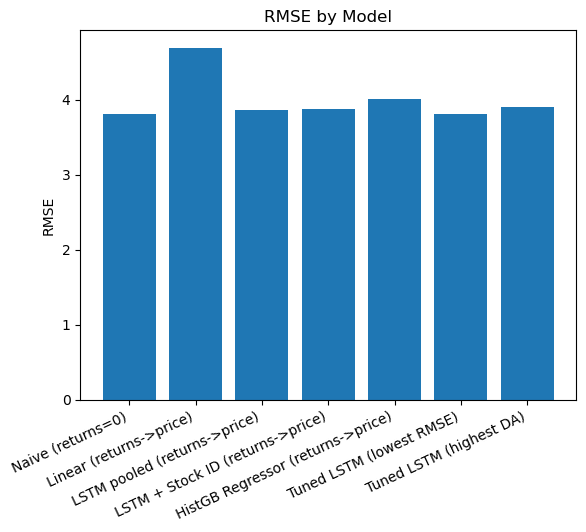

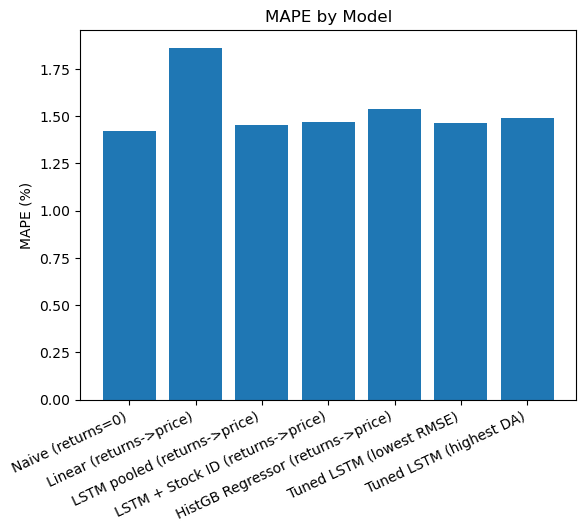

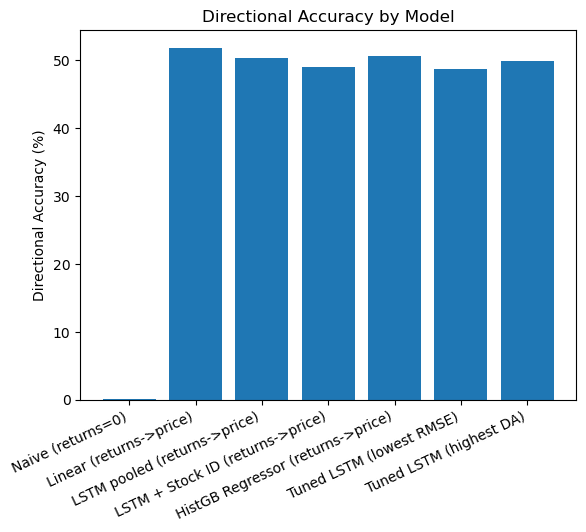

In [32]:
import matplotlib.pyplot as plt

# -----------------------------
# Build summary including tuned LSTMs
# -----------------------------
summary = pd.DataFrame([
    {"Model":"Naive (returns=0)", **baseline_naive},
    {"Model":"Linear (returns->price)", **baseline_linear},
    {"Model":"LSTM pooled (returns->price)", **lstm_plain_metrics},
    {"Model":"LSTM + Stock ID (returns->price)", **lstm_id_metrics},
    {"Model":"HistGB Regressor (returns->price)", **hgb_metrics},
    {"Model":"Tuned LSTM (lowest RMSE)", **best_rmse_cfg.to_dict()},
    {"Model":"Tuned LSTM (highest DA)", **best_da_cfg.to_dict()},
])

# Clean formatting
display(summary.style.format({
    "RMSE":"{:.3f}",
    "MAE":"{:.3f}",
    "MAPE":"{:.3f}",
    "Directional_Accuracy_%":"{:.2f}"
}))

# -----------------------------
# Visualizations
# -----------------------------

# RMSE bar
plt.figure()
plt.bar(summary["Model"], summary["RMSE"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("RMSE")
plt.title("RMSE by Model")
plt.show()

# MAPE bar
plt.figure()
plt.bar(summary["Model"], summary["MAPE"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("MAPE (%)")
plt.title("MAPE by Model")
plt.show()

# Directional Accuracy bar
mask = ~summary["Directional_Accuracy_%"].isna()
plt.figure()
plt.bar(summary["Model"][mask], summary["Directional_Accuracy_%"][mask])
plt.xticks(rotation=25, ha="right")
plt.ylabel("Directional Accuracy (%)")
plt.title("Directional Accuracy by Model")
plt.show()



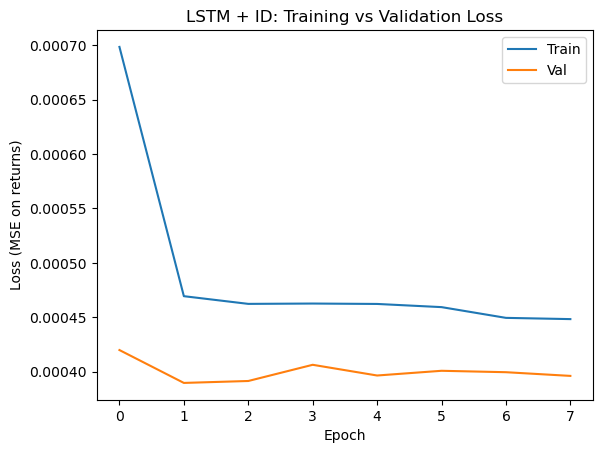

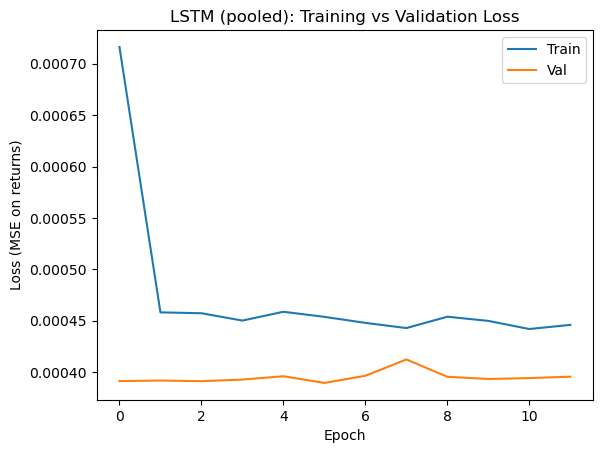

In [37]:
import matplotlib.pyplot as plt
if 'tr_loss_id' in globals() and 'va_loss_id' in globals():
    plt.figure(); plt.plot(tr_loss_id, label="Train"); plt.plot(va_loss_id, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss (MSE on returns)"); plt.title("LSTM + ID: Training vs Validation Loss"); plt.legend(); plt.show()

if 'tr_loss_p' in globals() and 'va_loss_p' in globals():
    plt.figure(); plt.plot(tr_loss_p, label="Train"); plt.plot(va_loss_p, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss (MSE on returns)"); plt.title("LSTM (pooled): Training vs Validation Loss"); plt.legend(); plt.show()


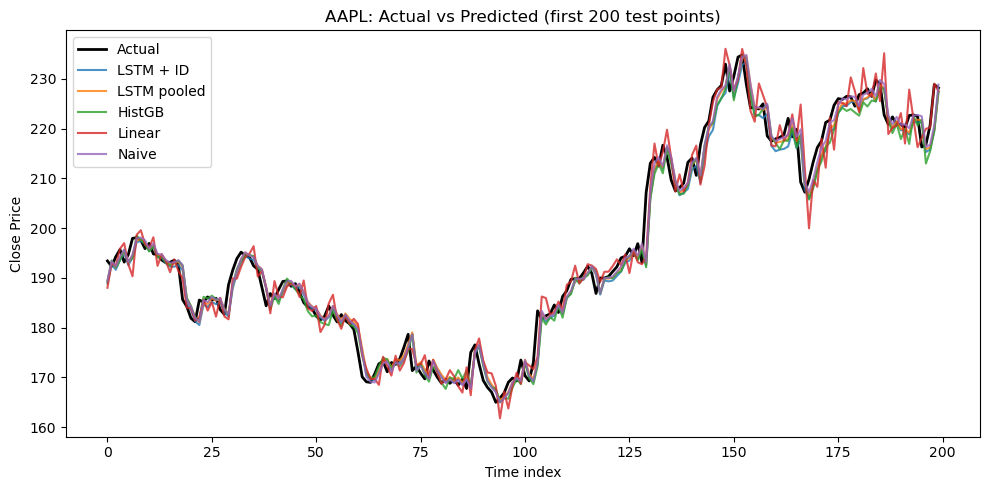

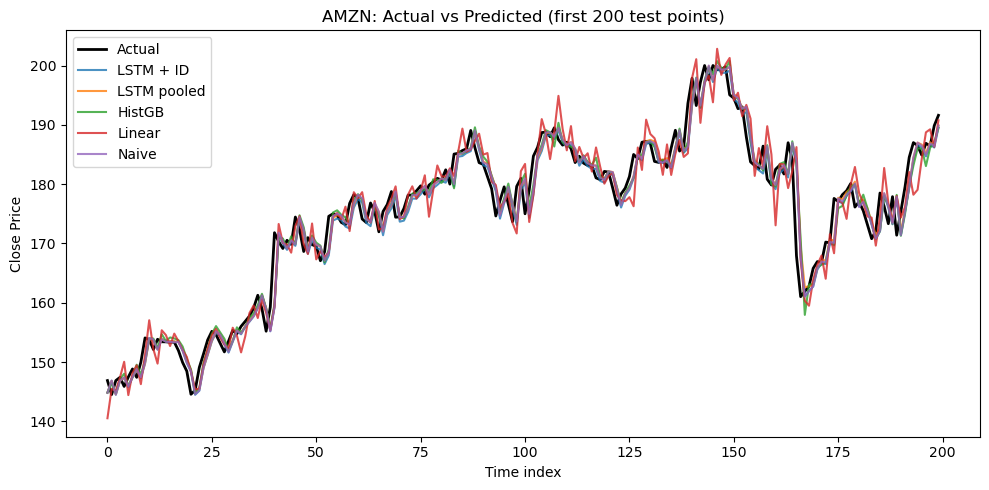

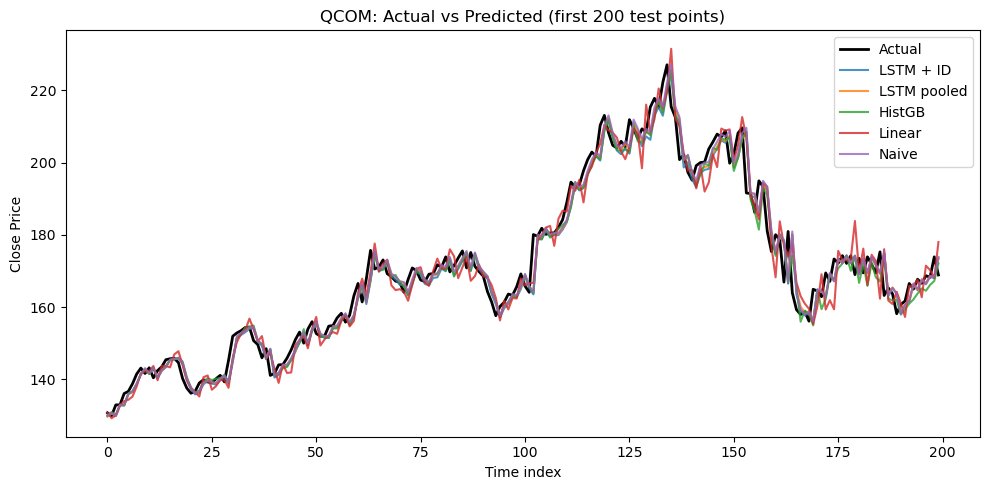

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# predictions dictionary (make sure these exist in your session)
preds = {}
if 'pred_id_price' in globals(): preds["LSTM + ID"] = pred_id_price
if 'pred_plain_price' in globals(): preds["LSTM pooled"] = pred_plain_price
if 'hgb_price_pred' in globals(): preds["HistGB"] = hgb_price_pred
if 'lin_ret_pred' in globals(): preds["Linear"] = tePrevC * np.exp(lin_ret_pred)
preds["Naive"] = tePrevC  # carry forward

tickers = sorted(np.unique(teID))
for t in tickers:
    mask = (teID == t)
    y_true = teNextC[mask]
    idx = np.arange(np.sum(mask))[:200]

    plt.figure(figsize=(10,5))
    plt.plot(idx, y_true[:200], label="Actual", linewidth=2, color="black")
    for name, yhat_all in preds.items():
        yhat = yhat_all[mask]
        plt.plot(idx, yhat[:200], label=name, alpha=0.8)
    plt.title(f"{t}: Actual vs Predicted (first 200 test points)")
    plt.xlabel("Time index"); plt.ylabel("Close Price")
    plt.legend(); plt.tight_layout(); plt.show()


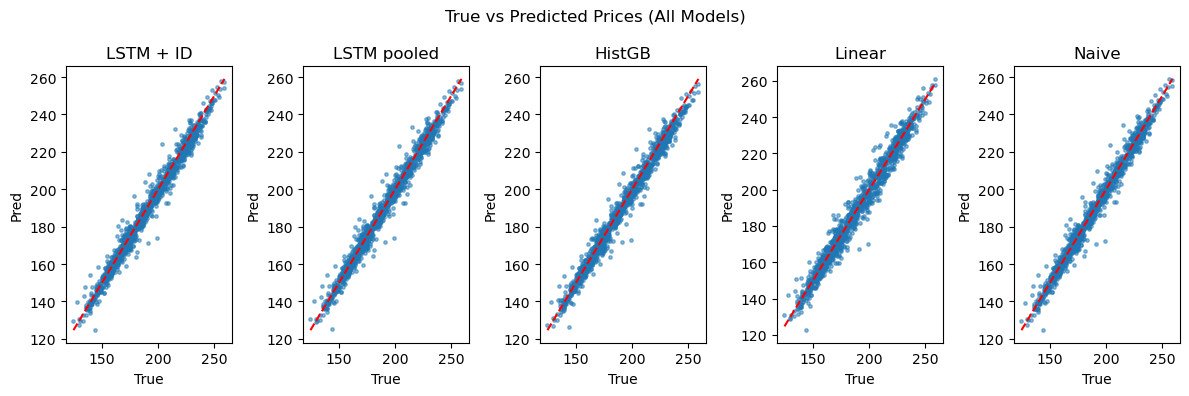

In [42]:
plt.figure(figsize=(12,4))
for i,(name,yhat) in enumerate(preds.items(),1):
    plt.subplot(1,len(preds),i)
    plt.scatter(teNextC, yhat, s=6, alpha=0.5)
    mn,mx = np.min(teNextC), np.max(teNextC)
    plt.plot([mn,mx],[mn,mx], color="red", linestyle="--")
    plt.title(name); plt.xlabel("True"); plt.ylabel("Pred")

plt.suptitle("True vs Predicted Prices (All Models)")
plt.tight_layout(); plt.show()


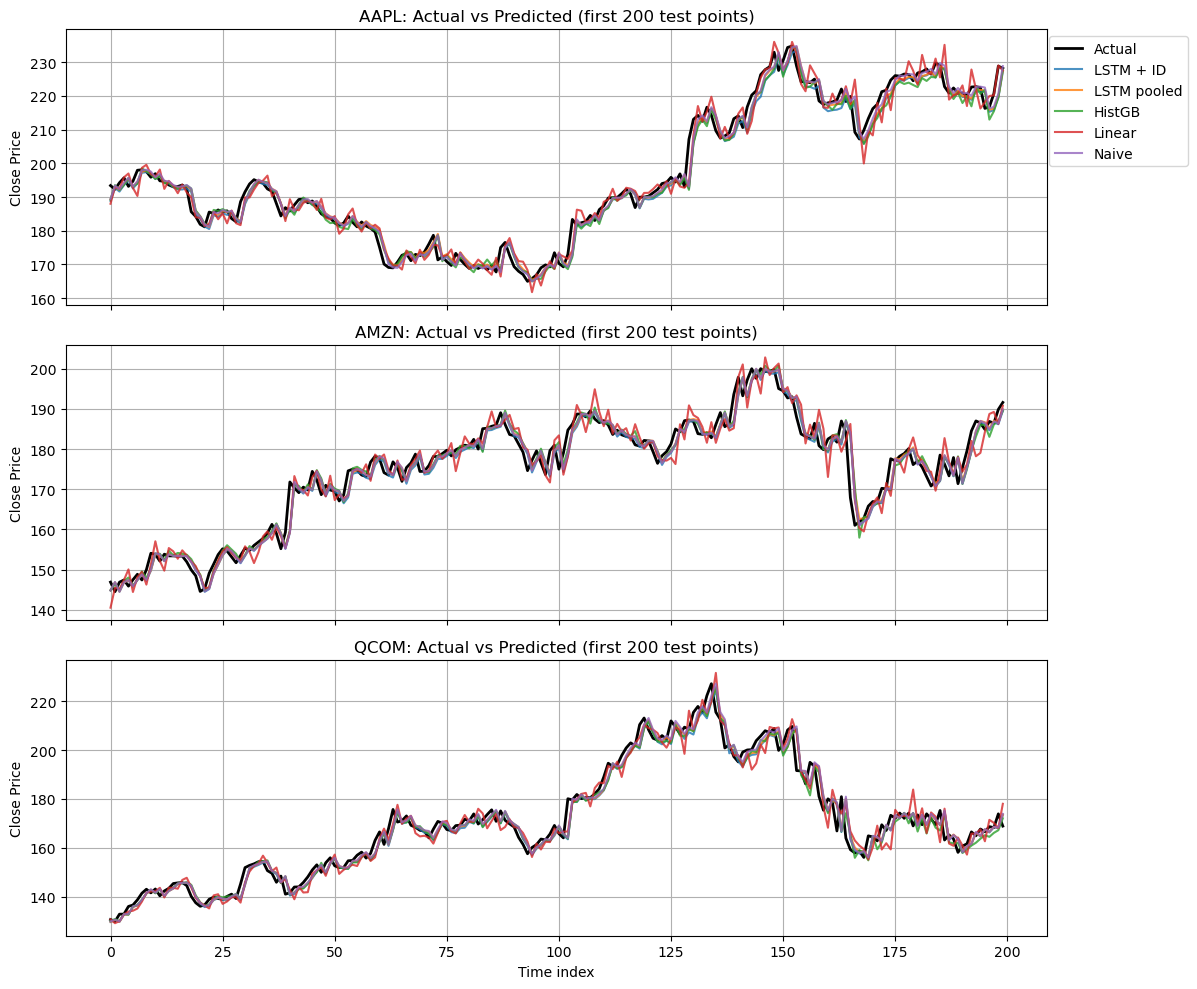

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Predictions dictionary
preds = {}
if 'pred_id_price' in globals(): preds["LSTM + ID"] = pred_id_price
if 'pred_plain_price' in globals(): preds["LSTM pooled"] = pred_plain_price
if 'hgb_price_pred' in globals(): preds["HistGB"] = hgb_price_pred
if 'lin_ret_pred' in globals(): preds["Linear"] = tePrevC * np.exp(lin_ret_pred)
preds["Naive"] = tePrevC  # carry-forward baseline

tickers = sorted(np.unique(teID))

# Create grid of subplots (3 rows, 1 col)
fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 10), sharex=True)

for i, t in enumerate(tickers):
    ax = axes[i]
    mask = (teID == t)
    y_true = teNextC[mask]
    idx = np.arange(np.sum(mask))[:200]

    # Actual
    ax.plot(idx, y_true[:200], label="Actual", linewidth=2, color="black")
    # Predictions
    for name, yhat_all in preds.items():
        yhat = yhat_all[mask]
        ax.plot(idx, yhat[:200], label=name, alpha=0.8)

    ax.set_title(f"{t}: Actual vs Predicted (first 200 test points)")
    ax.set_ylabel("Close Price")
    ax.grid(True)

axes[-1].set_xlabel("Time index")
axes[0].legend(loc="upper right", bbox_to_anchor=(1.15, 1))  # one legend outside
plt.tight_layout()
plt.show()


In [35]:
# Convert per-stock tuned results into overall averages
tuned_rmse_metrics = {
    "RMSE": best_rmse_df["RMSE"].mean(),
    "MAE": best_rmse_df["MAE"].mean(),
    "MAPE": best_rmse_df["MAPE"].mean(),
    "Directional_Accuracy_%": best_rmse_df["Directional_Accuracy_%"].mean()
}

tuned_da_metrics = {
    "RMSE": best_da_df["RMSE"].mean(),
    "MAE": best_da_df["MAE"].mean(),
    "MAPE": best_da_df["MAPE"].mean(),
    "Directional_Accuracy_%": best_da_df["Directional_Accuracy_%"].mean()
}


In [27]:
# Find best RMSE and best Directional Accuracy
best_rmse_idx = tune_df["RMSE"].idxmin()
best_da_idx = tune_df["Directional_Accuracy_%"].idxmax()

print("Best RMSE config:")
print(tune_df_display.loc[best_rmse_idx])
print("\nBest Directional Accuracy config:")
print(tune_df_display.loc[best_da_idx])


Best RMSE config:
Config                    Pooled (no ID) | W=30 | H=128
RMSE                                              3.812
MAE                                                2.71
MAPE                                              1.465
Directional_Accuracy_%                            48.76
Name: 2, dtype: object

Best Directional Accuracy config:
Config                    Pooled + Stock ID | W=60 | H=64
RMSE                                                  3.9
MAE                                                 2.804
MAPE                                                1.488
Directional_Accuracy_%                              49.89
Name: 5, dtype: object
